In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
# from nltools.mask import create_sphere, expand_mask
# from nltools.data import Brain_Data, Adjacency
# from nltools.stats import align
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
# from mvpa2.suite import 
import numpy as np
from sklearn.linear_model import RidgeCV
import numpy as np
import torch
from os.path import join as opj
from transformers import AutoProcessor, CLIPTextModel
import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
# from hyperalign import align
%matplotlib inline
from os import makedirs

/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class HyperAlign:
    def __init__(self, device,randomize=False,rank=300):
        self.device = device
        self.R=None
        self.c=None
        self.randomize=randomize
        self.rank=rank

        
    def randomized_svd(self,M, rank=None):
        M=M.double()
        m, n = M.shape

        # Step 1: Randomly generate a matrix G
        G = torch.randn(n, self.rank).to(M.device).double()

        # Step 2: Form a matrix H = MG
        H = M @ G

        # Step 3: Orthonormalize H
        Q, _ = torch.linalg.qr(H)

        # Step 4: Form the matrix T = Q.T @ M
        T = Q.T @ M

        # Step 5: Compute the SVD of T
        U_hat, s, V = torch.linalg.svd(T, full_matrices=False)

        # Step 6: Compute U = QU_hat
        U = Q @ U_hat

        return V.T, s, U


    def orthogonal_procrustes(self, A, B):
        A, B = A.to(self.device), B.to(self.device)

        product = A.T @ B
        if self.randomize:
            U, _, V = self.randomized_svd(product, self.rank)
        else:
            U, _, V = torch.linalg.svd(product)
        R = U @ V.T
        c = torch.trace(B.T @ (A @ R)) / torch.trace(A.T @ A)
        return R, c

    def fit(self,source,target):
        R, c = self.orthogonal_procrustes(source, target)
        self.R=R
        self.c=c
        print("fit completed")
    
    def align(self, source):
        
        assert self.R is not None, "Call fit before with source, target before"
        source = source.to(self.device)
        # R, c = self.orthogonal_procrustes(source, target)

        # Align the source to the target
        source_aligned = self.c * source @ self.R

        return source_aligned.cpu()


In [3]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Function to load the MNIST dataset
def load_mnist_dataset(batch_size=60000, shuffle=False):
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=shuffle)
    return train_loader

# 1. Load the entire MNIST dataset
train_loader = load_mnist_dataset()

# 2. Reshape and concatenate all the images
data = []
labels = []
for images, lbls in tqdm.tqdm(train_loader):
    images_flat = images.view(images.size(0), -1)  # Flatten the images
    data.append(images_flat)
    labels.append(lbls)

# Concatenate all the data and labels
data = torch.cat(data, out=torch.Tensor(len(train_loader.dataset), data[0].shape[1]))
labels = torch.cat(labels)

# Convert to numpy arrays
data_np = data.numpy()
labels_np = labels.numpy()


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


In [171]:

# 3. Apply PCA
pca = PCA(n_components=128).fit(data_np[:4096]) # Reduce to 2D for visualization

# # 6. Plot the explained variance ratio
# explained_variance_ratio = pca.explained_variance_ratio_
# plt.figure(figsize=(10, 6))
# plt.plot(np.cumsum(explained_variance_ratio))
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance Ratio')
# plt.grid(True)
# plt.show()

# # 7. Find the n_components able to explain the 95% of variance
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# n_components_95 = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1
# print(f"Number of components to explain 95% variance: {n_components_95}")

# # 8. Fit a PCA with this n_components
# pca_95 = PCA(n_components=n_components_95)
# pca_95_result = pca_95.fit_transform(flattened_image.reshape(1, -1))


In [172]:
data_np_res=pca.transform(data_np[:4096])

data_np_recon=pca.inverse_transform(data_np_res)

In [173]:
target_batch=data_np[512:]
noise_level=0.1

target=pca.transform(target_batch)
source=target+np.random.randn()*target.std()*noise_level

In [174]:
hyper_align = HyperAlign("cuda:0")

source = torch.tensor(source).float()
target = torch.tensor(target).float()
hyper_align.fit(source,target)


aligned_source=hyper_align.align(torch.tensor(source)).numpy()

#adjust values
final_mean=target.mean(0)
final_std=target.std(0)


aligned_source_adj=(aligned_source-aligned_source.mean(0))/(1e-8+aligned_source.std(0))
aligned_source_adj=final_std*aligned_source_adj+final_mean

fit completed


/tmp/ipykernel_589127/3466861712.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aligned_source=hyper_align.align(torch.tensor(source)).numpy()


In [40]:
# aligned_source_adj.min(), source.min()

Text(0.5, 1.0, 'recon aligned')

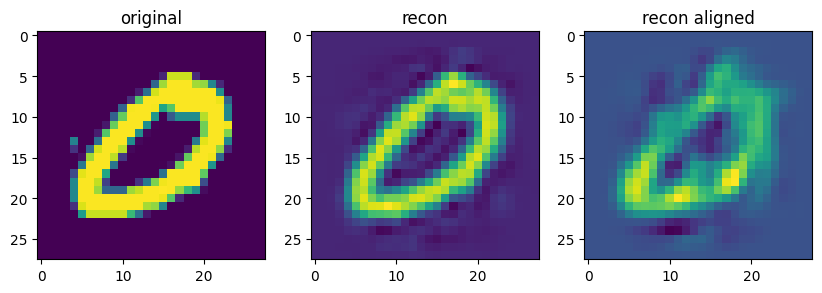

In [175]:
idx=7


fig,axs=plt.subplots(1,3,figsize=(10,3))

axs[0].imshow(target_batch[idx].reshape(28,28))
axs[0].set_title("original")
axs[1].imshow(pca.inverse_transform(source[idx:idx+1]).reshape(28,28))
axs[1].set_title("recon")

out=pca.inverse_transform(aligned_source_adj[idx:idx+1]).reshape(28,28)
# out=out>np.percentile(out,80)
axs[2].imshow(out)
axs[2].set_title("recon aligned")



(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.,
         3.,  4.,  2., 11., 46., 89., 56., 22.,  8.,  2.,  2.,  2.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-3.23545027, -3.06102967, -2.88660908, -2.71218848, -2.53776789,
        -2.36334729, -2.1889267 , -2.01450586, -1.84008539, -1.66566479,
        -1.49124408, -1.31682348, -1.14240289, -0.96798229, -0.7935617 ,
        -0.61914104, -0.44472045, -0.27029982, -0.09587921,  0.07854141,
         0.25296202,  0.42738262,  0.60180324,  0.77622384,  0.95064449,
         1.12506509,  1.29948568,  1.47390628,  1.64832687,  1.82274759,
         1.99716818,  2.17158866,  2.34600949,  2.52043009,  2.69485068,
         2.86927128,  3.04369187,  3.21811247,  3.39253306,  3.56695366,
         3.74137425,  3.91579485,  4.09021568,  4.26463604,  4.43905687,
         4.61347723,  4.78789806,  4.96231842,  5.13673925,

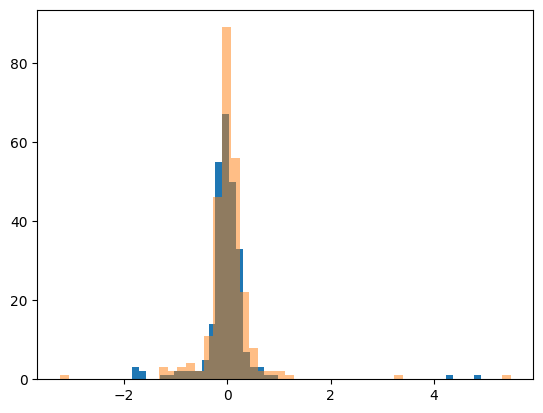

In [135]:
plt.hist(aligned_source_adj[idx:idx+1],bins=50)
plt.hist(source[idx:idx+1],alpha=0.5,bins=50)


fit completed


Text(0.5, 1.0, 'recon aligned')

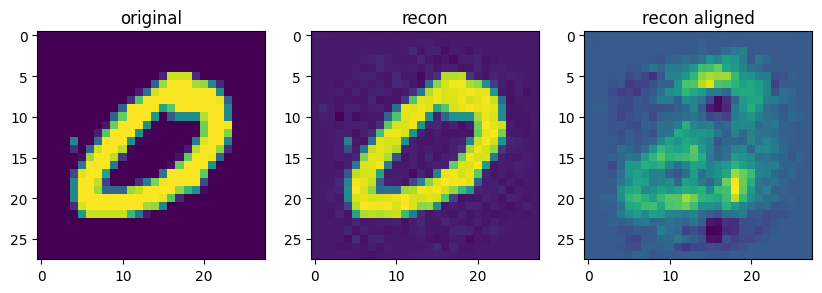

In [176]:
pca_many = PCA(n_components=512,svd_solver="auto").fit(data_np[:512]) # Reduce to 2D for visualization

data_np_res_many=pca_many.transform(data_np[:4096])
data_np_recon_many=pca_many.inverse_transform(data_np_res_many)

target_batch_many=data_np[512:]
noise_level=0.1

target_many=pca_many.transform(target_batch_many)
source_many=target_many+np.random.randn()*target_many.std()*noise_level


hyper_align_many = HyperAlign("cuda:0")

source_many = torch.tensor(source_many).float()
target_many = torch.tensor(target_many).float()
hyper_align_many.fit(source_many,target_many)


aligned_source_many=hyper_align_many.align(source_many).numpy()

#adjust values
final_mean_many=target_many.mean(0)
final_std_many=target_many.std(0)


aligned_source_adj_many=(aligned_source_many-aligned_source_many.mean(0))/(1e-8+aligned_source_many.std(0))
aligned_source_adj_many=final_std_many*aligned_source_adj_many+final_mean_many

# print(data_np_recon_many.shape)

idx=7


fig,axs=plt.subplots(1,3,figsize=(10,3))

axs[0].imshow(target_batch_many[idx].reshape(28,28))
axs[0].set_title("original")
axs[1].imshow(pca_many.inverse_transform(source_many[idx:idx+1]).reshape(28,28))
axs[1].set_title("recon")

out=pca_many.inverse_transform(aligned_source_adj_many[idx:idx+1]).reshape(28,28)
# out=out>np.percentile(out,80)
axs[2].imshow(out)
axs[2].set_title("recon aligned")

